In [1]:

import networkx as nx
from geopy.distance import great_circle
import geohash
import geopandas as gpd
import osmnx as ox
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import math
import contextily as cx
from shapely.geometry import Polygon,Point
from shapely import wkt,ops
import colorsys
from sklearn.preprocessing import StandardScaler
from scipy import spatial
import random
from scipy.spatial import distance_matrix
from scipy.stats import pearsonr
import matplotlib.patches as mpatches


In [2]:
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.sans-serif'] = ['Arial'] + ['DejaVu Sans',
                              'Bitstream Vera Sans',
                              'Computer Modern Sans Serif',
                              'Lucida Grande',
                              'Verdana',
                              'Geneva',
                              'Lucid',
                              'Arial',
                              'Helvetica',
                              'Avant Garde',
                              'sans-serif']

In [3]:
for country_abbrv in ['co', 'in', 'mx']:
    daily_od_fname = f'od_{country_abbrv}_agg5_3h.csv'
    daily_od = pd.read_csv(daily_od_fname)
    geohashes = list(set(daily_od.start_geohash5.unique()).union(set(daily_od.end_geohash5.unique())))
    geohash_coord = {gh:geohash.decode(gh) for gh in geohashes}
    geohash_bbox = {gh: geohash.bbox(gh) for gh in geohashes}

    gh_pt = {}
    tags = {'public_transport': ['platform','station'],
            'amenity':'bus_station',
            'highway': 'bus_stop'}
    # Download the points of interest (POIs) for the transit stops
    for gh in geohashes:   
        try:
            gh_pt[gh]=ox.features_from_bbox(north=geohash_bbox[gh]['n'], south=geohash_bbox[gh]['s'], east=geohash_bbox[gh]['e'], west=geohash_bbox[gh]['w'], tags=tags) 
        except ox._errors.InsufficientResponseError:
            gh_pt[gh] = pd.DataFrame()

    with open(f'country_abbrv}_pt_density.pkl', 'wb') as handle:
        pickle.dump(gh_pt, handle, protocol=pickle.HIGHEST_PROTOCOL)
            

## Read Transit Stop Density

In [94]:
from ast import literal_eval


In [95]:
country_geohashes = {}
country_bbox_gdf = {}
country_urbanicity ={}
for country_abbrv in ['co', 'mx', 'in']:#['co', 'mx', 'in']:
    daily_od_fname = f'od_{country_abbrv}_agg5_3h.csv'
    daily_od = pd.read_csv(daily_od_fname)
    country_geohashes[country_abbrv] = list(set(daily_od.start_geohash5.unique()).union(set(daily_od.end_geohash5.unique())))
    
    geohash_bbox = {gh: geohash.bbox(gh) for gh in country_geohashes[country_abbrv]}
    gdf = gpd.GeoDataFrame([[gh, Polygon([(geohash_bbox[gh]['w'], geohash_bbox[gh]['s']),
                                     (geohash_bbox[gh]['e'], geohash_bbox[gh]['s']),
                                     (geohash_bbox[gh]['e'], geohash_bbox[gh]['n']), 
                                     (geohash_bbox[gh]['w'], geohash_bbox[gh]['n'])])] for gh in country_geohashes[country_abbrv]],
                       columns=['gh5', 'geometry'], geometry='geometry', crs="EPSG:4326")
    country_urbanicity[country_abbrv] =  pd.read_csv(f'{country_abbrv}_urbanicity_v2.csv')
    country_bbox_gdf[country_abbrv] = gpd.GeoDataFrame(gdf.merge(country_urbanicity[country_abbrv], how='left', on='gh5'), geometry='geometry', crs="EPSG:4326")

/home/jupyter-niyer/README
/home/jupyter-niyer/README
/home/jupyter-niyer/README
/home/jupyter-niyer/README
/home/jupyter-niyer/README
/home/jupyter-niyer/README


In [96]:
country_city = {}
for ca in ['co', 'mx', 'in']:
    biggest_cities = country_urbanicity[ca][country_urbanicity[ca].area_type=='urban'].groupby('cluster_id').agg({'area_type':'count'}).reset_index()
    print(biggest_cities.sort_values('area_type',ascending=False)[:4])
    biggest_cities = list(biggest_cities.sort_values('area_type',ascending=False)[:4].cluster_id)
    country_city[ca] = biggest_cities

   cluster_id  area_type
2          13         55
6          32         21
3          17         18
1          10         16
    cluster_id  area_type
0            1        421
11          42        121
3           14        111
10          37         99
    cluster_id  area_type
7           32        136
2           13         90
17          81         74
20          99         70


In [98]:
pt_density = []
for ca in ['co', 'mx', 'in']:
    urbanicity_df = pd.read_csv(f'{ca}_urbanicity_v2.csv')
    mob_eff = country_weekday_eff[ca].groupby(['start_geohash5','short_est', 'time_id']).agg({'delta':'mean'}).reset_index().rename({'start_geohash5':'gh5'},axis=1)
    mob_eff = mob_eff[mob_eff.time_id.isin(range(8))].groupby(['gh5','short_est']).agg({'delta':'median'}).reset_index()

    mob_eff = mob_eff[['gh5', 'short_est', 'delta']].merge(urbanicity_df, how='left', on='gh5')
    with open(f'processed_data/{ca}_pt_density.pkl', 'rb') as handle:
        x = pickle.load(handle)
    x = x.merge(mob_eff, how='left', on='gh5')
    # for c in  ['points', 'xv', 'yv', 'density_grid', 'hull_vertices']:
    #     x[c] = x[c].apply(literal_eval)
    x['country'] = ca
    x['no_pts'] = [len(xx) for xx in x.points]
    x['no_pts_norm'] = (x['no_pts']-x['no_pts'].min())/(x['no_pts'].max()-x['no_pts'].min())
    x['density_norm'] = (x['density']-x['density'].min())/(x['density'].max()-x['density'].min())
    x['score'] = (0.5*x['no_pts_norm']) + (0.5 * x['coverage_ratio']) # mean
    # x['score'] = np.sqrt(x['no_pts_norm'] * x['coverage_ratio'])
    x['score'] = x['score'].fillna(0)
    x['score_bin'] = pd.qcut(x['score'], q=4, labels=False, duplicates='drop')
    x['delta_bin'] = pd.qcut(x['delta'], q=4, labels=False, duplicates='drop')
    x['area_short'] = x['area_type'] + '_' + x['short_est'].astype(str)

    with open(f'{ca}_{tt}_density.pkl', 'wb') as handle:
        pickle.dump(x, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    pt_density.append(x)

pt_density = pd.concat(pt_density)


/home/jupyter-niyer/README
/home/jupyter-niyer/README
/home/jupyter-niyer/README
/home/jupyter-niyer/README
/home/jupyter-niyer/README
/home/jupyter-niyer/README


In [112]:
gh_score = {'ttnfv':0.793101,
 'ttnfg':0.470864	,
 'ttp51':0.108218,
 }

in
32


(76.822998046875, 77.644775390625, 28.21728515625, 29.08740234375)

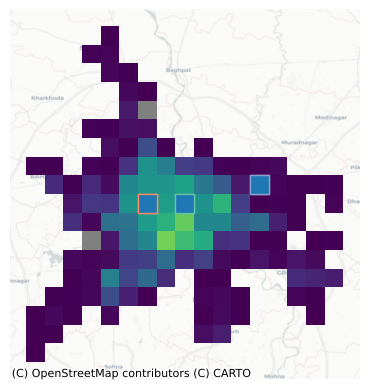

In [133]:
ca = 'in'
fig,ax=plt.subplots()
print(ca)
city = cs[0]
print(city)
data = road_density[(road_density.country==ca) & ((road_density.cluster_id==city) | (road_density.closest_city==city))]
data = road_density[(road_density.country==ca) & (road_density.cluster_id==city)]
gdf = country_bbox_gdf[ca][(country_bbox_gdf[ca].cluster_id==city)] [['gh5', 'geometry']] # | (country_bbox_gdf[ca].closest_city==city)][['gh5', 'geometry']]
# gdf = country_bbox_gdf[ca][(country_bbox_gdf[ca].cluster_id==city) | (country_bbox_gdf[ca].closest_city==city)][['gh5', 'geometry']]

data = gpd.GeoDataFrame(gdf.merge(data, how='left', on='gh5'), geometry='geometry', crs='EPSG:4326')

data.plot(ax=ax, color='grey')
data.plot('score', cmap='viridis',ax=ax, vmin=0, vmax=1)
for i, gh in enumerate(gh_score.keys()):
    data[data.gh5==gh].plot(color=None, edgecolor=sns.color_palette('Set2')[i], ax=ax)
ax.set_facecolor('lightgrey')
cx.add_basemap(ax,
               crs=country_bbox_gdf[ca].crs.to_string(),
               source=cx.providers.CartoDB.Positron, zoom=10
          )
ax.axis('off')

In [111]:
# data.sort_values('score',ascending=False)
data[data.score>0.1].sort_values('score',ascending=True)

,gh5,geometry,points,hull_area,bbox_area,coverage_ratio,density,xv,yv,density_grid,...,area_type,closest_city,country,no_pts,no_pts_norm,density_norm,score,score_bin,delta_bin,area_short
14,ttp51,"POLYGON ((77.38770 28.65234, 77.43164 28.65234...","[[4481397.470012317, 16776681.666323312], [448...",5.077273e+06,2.782472e+07,0.182473,4.312712e-07,"[[4478617.024356352, 4478682.339435466, 447874...","[[16772402.8734016, 16772402.8734016, 16772402...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,urban,NaN,in,12.0,0.033962,0.024882,0.108218,3.0,2.0,urban_True
13,ttp51,"POLYGON ((77.38770 28.65234, 77.43164 28.65234...","[[4481397.470012317, 16776681.666323312], [448...",5.077273e+06,2.782472e+07,0.182473,4.312712e-07,"[[4478617.024356352, 4478682.339435466, 447874...","[[16772402.8734016, 16772402.8734016, 16772402...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,urban,NaN,in,12.0,0.033962,0.024882,0.108218,3.0,1.0,urban_False
154,ttng0,"POLYGON ((76.99219 28.65234, 77.03613 28.65234...","[[4522128.540710415, 16761341.872824678], [452...",5.977075e+06,2.801053e+07,0.213387,1.785043e-07,"[[4520967.840588542, 4521033.542550944, 452109...","[[16758276.208602887, 16758276.208602887, 1675...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,urban,NaN,in,5.0,0.007547,0.006888,0.110467,3.0,1.0,urban_True
135,ttp1g,"POLYGON ((77.47559 28.43262, 77.51953 28.43262...","[[4483710.463390217, 16805681.34675852], [4478...",6.050553e+06,2.787933e+07,0.217027,3.228198e-07,"[[4477969.571344656, 4478034.864754812, 447810...","[[16802182.483195815, 16802182.483195815, 1680...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,urban,NaN,in,9.0,0.022642,0.017162,0.119834,3.0,0.0,urban_False
136,ttp1g,"POLYGON ((77.47559 28.43262, 77.51953 28.43262...","[[4483710.463390217, 16805681.34675852], [4478...",6.050553e+06,2.787933e+07,0.217027,3.228198e-07,"[[4477969.571344656, 4478034.864754812, 447810...","[[16802182.483195815, 16802182.483195815, 1680...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,urban,NaN,in,9.0,0.022642,0.017162,0.119834,3.0,2.0,urban_True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,ttnft,"POLYGON ((77.21191 28.56445, 77.25586 28.56445...","[[4504287.916462503, 16778530.522783153], [450...",2.394597e+07,2.794554e+07,0.856880,6.476883e-06,"[[4500976.424364576, 4501041.936784817, 450110...","[[16776831.103656797, 16776831.103656797, 1677...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,urban,NaN,in,181.0,0.671698,0.455256,0.764289,3.0,2.0,urban_True
82,ttnfk,"POLYGON ((77.16797 28.52051, 77.21191 28.52051...","[[4508835.527505055, 16784441.977432296], [451...",2.600155e+07,2.798561e+07,0.929104,6.217482e-06,"[[4507462.153968393, 4507527.722333718, 450759...","[[16780605.86341708, 16780605.86341708, 167806...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,urban,NaN,in,174.0,0.645283,0.436790,0.787194,3.0,2.0,urban_True
81,ttnfk,"POLYGON ((77.16797 28.52051, 77.21191 28.52051...","[[4508835.527505055, 16784441.977432296], [451...",2.600155e+07,2.798561e+07,0.929104,6.217482e-06,"[[4507462.153968393, 4507527.722333718, 450759...","[[16780605.86341708, 16780605.86341708, 167806...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,urban,NaN,in,174.0,0.645283,0.436790,0.787194,3.0,2.0,urban_False
149,ttnfv,"POLYGON ((77.21191 28.60840, 77.25586 28.60840...","[[4501332.773734739, 16777944.43815265], [4501...",2.237717e+07,2.792622e+07,0.801296,7.555624e-06,"[[4499204.187426394, 4499269.686911439, 449933...","[[16771491.501581423, 16771491.501581423, 1677...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,urban,NaN,in,211.0,0.784906,0.532049,0.793101,3.0,3.0,urban_False


In [240]:
def plot_score(row, score, fname='')
    G = ox.graph_from_polygon(data[data.gh5==k].iloc[0].geometry)
    G = ox.projection.project_graph(G,to_crs=country_proj['in'])
    ox.plot_graph(G, node_size=0, edge_color="k", edge_linewidth=0.25,bgcolor=None, show=False, ax=ax)
    
    # sns.kdeplot(x=row.points[:, 0], y=row.points[:, 1],cmap='Reds', alpha=0.6, ax=ax, fill=True)
    ax.plot(np.append(row.points[row.hull_vertices, 0], row.points[row.hull_vertices[0], 0]), 
            np.append(row.points[row.hull_vertices, 1], row.points[row.hull_vertices[0], 1]), 'b-', lw=2, label='Convex Hull')
    ax.scatter(row.points[:, 0] , row.points[:, 1], label='Points', alpha=1, s=20, color='k')
    plt.legend(fontsize=13)
    plt.title(f"PT Score: {score}", fontsize=18)
    
    plt.show()
    

In [159]:
import osmnx as ox

In [222]:
# for k,v in gh_score.items():
#     G = ox.graph_from_polygon(data[data.gh5==k].iloc[0].geometry)
#     fig, ax = ox.plot_graph(G, node_size=0, edge_color="k", edge_linewidth=0.25,bgcolor='white')

#     buf = BytesIO()
#     fig.savefig(buf, format='pdf', bbox_inches='tight')
#     buf.seek(0)
#     minio_helper.save_file(f'netmob_2024/final_figures/processing/{k}_pt_score_road_nx.pdf', buf, obj_type='image')


/home/jupyter-niyer/README
Variable data is successfully uploaded as 'netmob_2024/final_figures/processing/convex_0.793_pt_score.pdf' to bucket 'niyer-processed'.


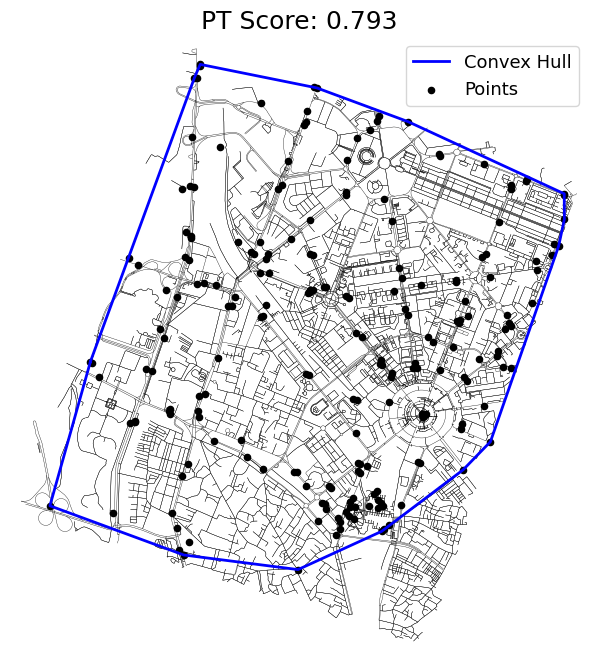

/home/jupyter-niyer/README
Variable data is successfully uploaded as 'netmob_2024/final_figures/processing/convex_0.471_pt_score.pdf' to bucket 'niyer-processed'.


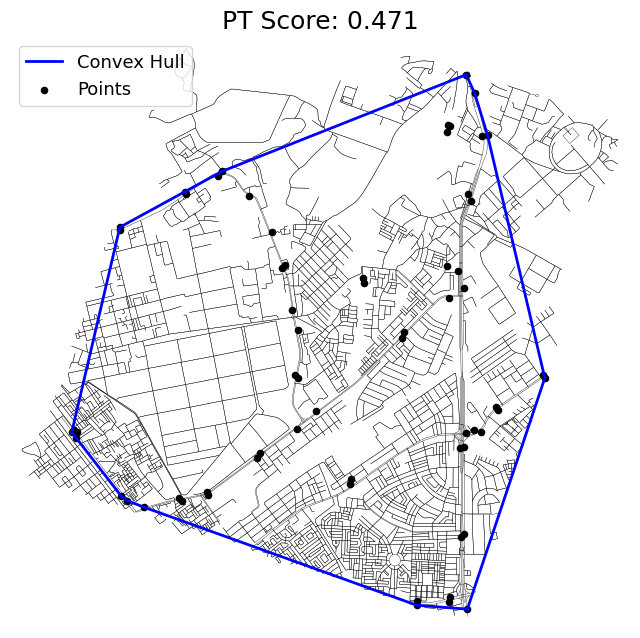

/home/jupyter-niyer/README
Variable data is successfully uploaded as 'netmob_2024/final_figures/processing/convex_0.108_pt_score.pdf' to bucket 'niyer-processed'.


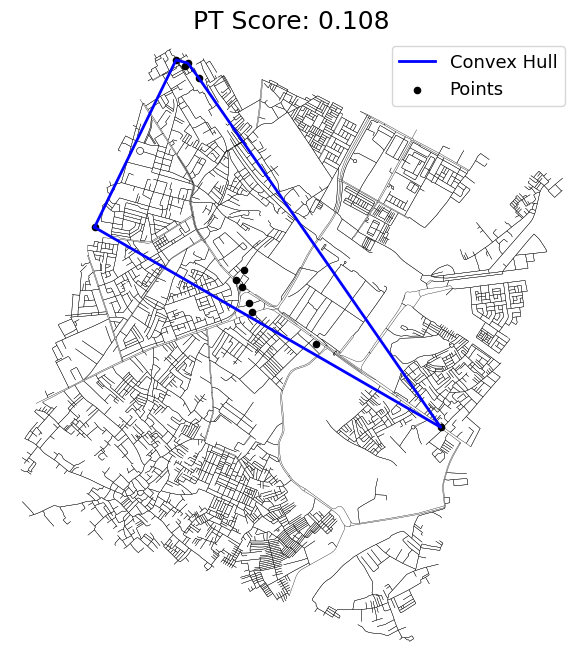

In [241]:
for k,v in gh_score.items():
    row = data[data.gh5==k].iloc[0]
    plot_score(row, round(v, 3), fname='convex')

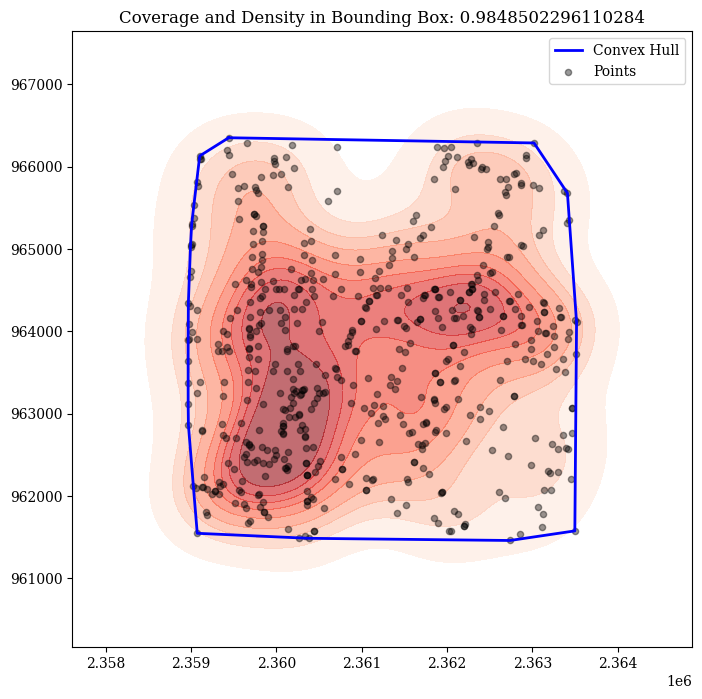

In [951]:
plot_score(road_density.iloc[2311], road_density.iloc[2311].score)
#high score, low eff

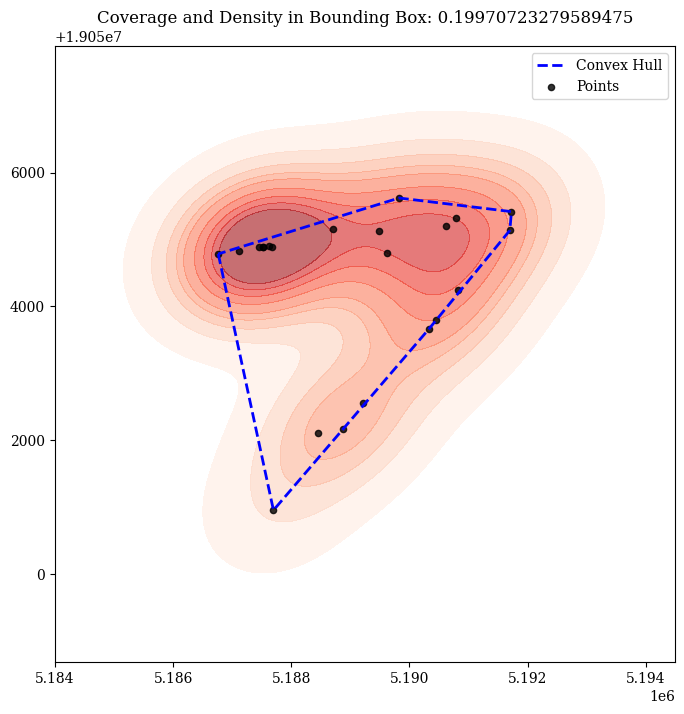

In [930]:
plot_score(road_density.iloc[4863], road_density.iloc[4863].score)
#high score, low eff